<h1 style="background-color:DodgerBlue;"> Anamoly detection ||  Deep Learning ➤ Autoencoder </h1>

## 🧪 **Scenario: Detect Anomalies in User Login activity **
- Goal: Detect early anomalies in user login activity and prevent cyber crimes.

🔐 **User Login Activity** is a rich and practical area for anomaly detection — and often the first line of defense in cybersecurity.


## 🧠 Key Features for User Login Anomaly Detection

Here's a breakdown of common features used in detecting login anomalies. These are often engineered from raw logs.

| 🧬 Feature Name                  | 📘 Description |
|-------------------------------|----------------|
| `login_hour`                  | Hour of login (0–23); unusual hours could be suspicious |
| `geo_distance_km`             | Distance from last login location (geolocation/IP lookup) |
| `device_type`                 | Laptop / mobile / tablet / smartTV (often one-hot encoded) |
| `os_browser_signature`        | Encoded combination of OS and browser (e.g., Windows+Chrome) |
| `failed_login_count`          | Count of failed login attempts within recent time window |
| `session_duration_sec`        | Duration of current login session (short bursts could be bots) |
| `login_day_of_week`           | Encoded weekday (e.g., weekend logins might be odd for corporate users) |
| `user_tenure_days`            | How long since the user first registered |
| `account_age_hours`           | Age of account at login time |
| `login_frequency_past_week`  | Number of logins in the past 7 days (used to detect spikes) |
| `ip_reputation_score`         | Score based on whether the IP is from a known proxy/VPN/blacklist |
| `is_known_device`             | Boolean: is this a previously seen device for the user |
| `country_code`                | Country of login (can be encoded or used to detect geo jumps) |

---

### 🛠 Feature Engineering Notes:
- `geo_distance_km` is calculated using the **Haversine formula** between the current login's lat/lon and the last login location.
- `is_known_device` often comes from tracking browser fingerprints or device IDs.
- `ip_reputation_score` can be fetched from 3rd party services (e.g., IPQualityScore, MaxMind).

---

### 🧪 Anomalies Might Look Like:
- Login from **Russia** at 3 AM with a **new device** when the user usually logs in from **California** at 9 AM.
- A sudden **burst of failed logins** before a successful login.
- Login from a **high-rid the door to the **cyber-defense matrix** 😎

### 🐍 **1. Generate Simulated Login Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split




# Set seed for reproducibility
np.random.seed(42)

# Normal login patterns (1000 samples)
normal_data = {
    'login_hour': np.random.normal(9, 2, 1000),  # 9 AM typical login
    'geo_distance_km': np.random.normal(5, 2, 1000),  # small geo shifts
    'failed_login_count': np.random.poisson(0.3, 1000),  # rare fails
    'session_duration_sec': np.random.normal(1800, 600, 1000),  # 30 min avg session
    'login_frequency_past_week': np.random.normal(7, 2, 1000),  # daily logins
    'is_known_device': np.random.binomial(1, 0.95, 1000),  # usually known
    'ip_reputation_score': np.random.normal(0.9, 0.05, 1000),  # good IPs
    'weekday': np.random.randint(0, 5, 1000)  # Mon-Fri
}

# Anomalous logins (50 samples)
anomalies = {
    'login_hour': np.random.normal(2, 1, 50),  # odd hour
    'geo_distance_km': np.random.normal(2000, 500, 50),  # different country
    'failed_login_count': np.random.poisson(5, 50),  # brute force pattern
    'session_duration_sec': np.random.normal(60, 30, 50),  # short bot-like
    'login_frequency_past_week': np.random.normal(30, 10, 50),  # bursty
    'is_known_device': np.random.binomial(1, 0.1, 50),  # new device
    'ip_reputation_score': np.random.normal(0.2, 0.1, 50),  # bad IP
    'weekday': np.random.randint(5, 7, 50)  # weekend logins
}

df_normal = pd.DataFrame(normal_data)
df_anomaly = pd.DataFrame(anomalies)
df = pd.concat([df_normal, df_anomaly], ignore_index=True).sample(frac=1).reset_index(drop=True)
df.head()

,login_hour,geo_distance_km,failed_login_count,session_duration_sec,login_frequency_past_week,is_known_device,ip_reputation_score,weekday
0,10.030095,2.194789,1,1157.488549,5.778285,1,0.923950,2
1,7.492528,6.706831,0,1429.414994,2.147216,1,0.868071,4
2,6.420078,9.125050,0,2024.009136,5.868847,1,0.939207,4
3,8.081278,5.352883,0,1820.416447,7.135677,1,0.820493,1
4,9.984903,2.944650,0,2397.670929,5.955737,1,0.882776,2


### ⚙️ **2. Preprocess & Split Data**

In [2]:
# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Train only on normal samples
X_train = scaler.transform(df_normal)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

### 🧠 **3. Build & Train the Autoencoder**

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LambdaCallback


# Define input dimension from the training data shape
input_dim = X_train.shape[1]

# Build the Autoencoder model architecture
input_layer = Input(shape=(input_dim,))  # Input layer with the shape of each data sample
# Encoder part - First layer with 32 neurons, using L1 regularization for sparsity (activity_regularizer)
encoded = Dense(32, activation='relu', activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(16, activation='relu')(encoded)  # Second encoding layer with 16 neurons

# Decoder part - First layer of the decoder with 32 neurons
decoded = Dense(32, activation='relu')(encoded)
# Final layer that reconstructs the input data, outputting as many features as the input
decoded = Dense(input_dim, activation='linear')(decoded)  # Linear activation for output layer

# Define the Autoencoder model (mapping input to the reconstructed output)
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model with Adam optimizer and mean squared error loss (since it's reconstruction)
autoencoder.compile(optimizer='adam', loss='mse')

# Custom callback function to print loss every 5 epochs
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch + 1}: loss = {logs['loss']}, val_loss = {logs['val_loss']}")
    if (epoch + 1) % 5 == 0 else None  # Print only every 5th epoch (for concise output)
)

# Train the autoencoder with the custom callback
history = autoencoder.fit(X_train, X_train,  # Training data is the same as the target (autoencoder)
                          epochs=50,  # Number of epochs to train
                          batch_size=32,  # Batch size for each update
                          validation_data=(X_val, X_val),  # Validation set to track overfitting
                          verbose=0,  # Suppress verbose logging
                          callbacks=[print_callback])  # Add the custom print callback to show loss every 5 epochs


Epoch 5: loss = 0.09352962672710419, val_loss = 0.06583552062511444
Epoch 10: loss = 0.02808230184018612, val_loss = 0.022304873913526535
Epoch 15: loss = 0.012703534215688705, val_loss = 0.010214883834123611
Epoch 20: loss = 0.008360943756997585, val_loss = 0.007588846143335104
Epoch 25: loss = 0.006665091961622238, val_loss = 0.006243571639060974
Epoch 30: loss = 0.0057594566605985165, val_loss = 0.005510792136192322
Epoch 35: loss = 0.005113838706165552, val_loss = 0.004878863226622343
Epoch 40: loss = 0.004586933646351099, val_loss = 0.004508659243583679
Epoch 45: loss = 0.004131673369556665, val_loss = 0.004212482832372189
Epoch 50: loss = 0.0037380773574113846, val_loss = 0.0038614862132817507


### 📉 **4. Visualize Training Loss: Train & Val Loss**

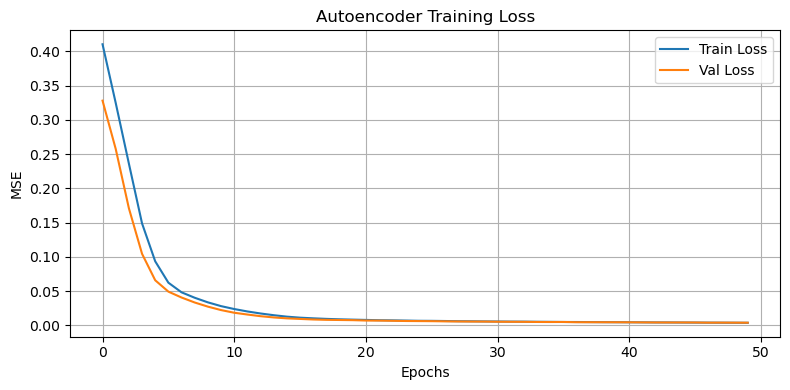

In [4]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 📉 **5. Visualize Re-Construction Error**

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


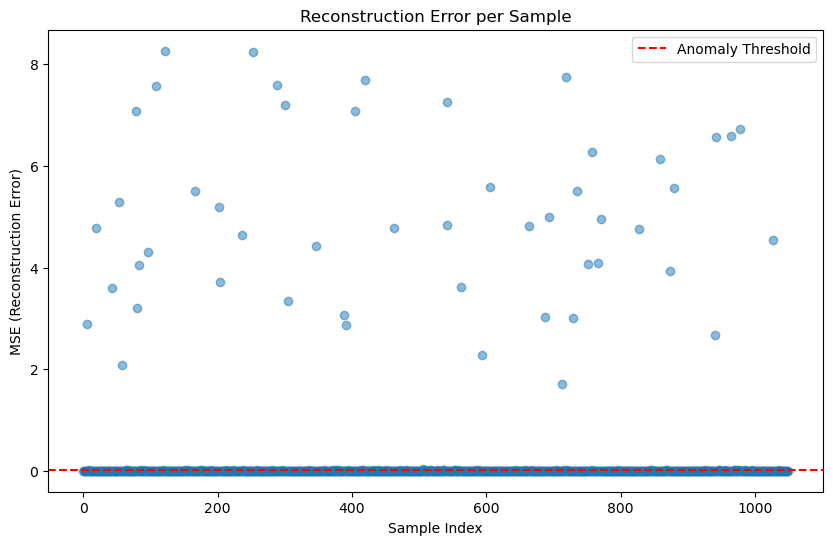

In [5]:
# Predict the reconstructed data using the trained autoencoder
X_reconstructed = autoencoder.predict(X_scaled)

# Calculate the Mean Squared Error (MSE) between the original data and the reconstructed data
recon_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)

# Set a threshold for anomaly detection (based on the reconstruction error)
threshold = np.percentile(recon_error, 95)  # 95th percentile as the threshold for anomaly detection

# Plot the reconstruction error for each sample
plt.figure(figsize=(10, 6))
plt.scatter(range(len(recon_error)), recon_error, alpha=0.5)
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title("Reconstruction Error per Sample")
plt.xlabel("Sample Index")
plt.ylabel("MSE (Reconstruction Error)")
plt.legend()
plt.show()


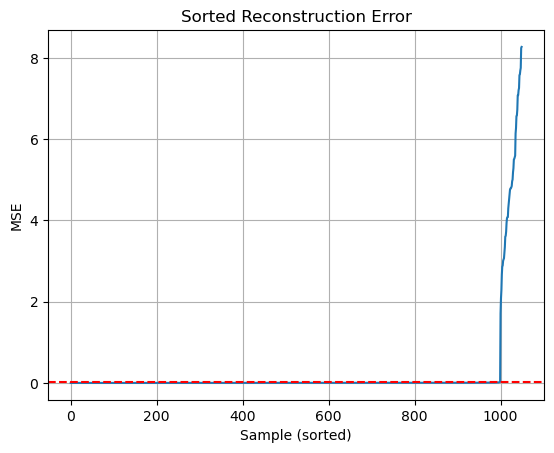

In [6]:
plt.plot(sorted(recon_error))
plt.axhline(threshold, color='red', linestyle='--')
plt.title("Sorted Reconstruction Error")
plt.xlabel("Sample (sorted)")
plt.ylabel("MSE")
plt.grid(True)


### 📉 **6. Visualize Latent Space Visualization (PCA or t-SNE)**

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


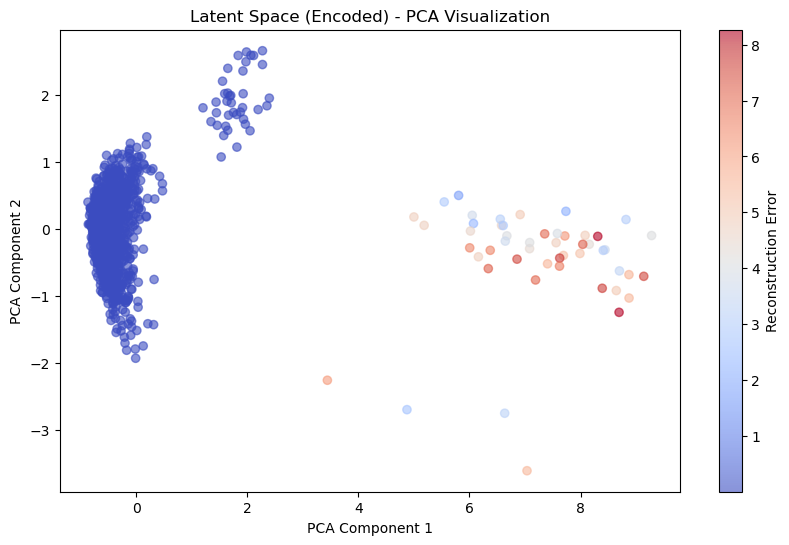

In [7]:
from sklearn.decomposition import PCA

# Get the encoded features (latent space representation) from the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)  # Extract the encoder part of the autoencoder
X_encoded = encoder.predict(X_scaled)  # Encode the scaled data to the latent space

# Reduce the dimensionality of the encoded features using PCA (2 components for 2D visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# Plot the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c=recon_error, cmap='coolwarm')  # Use reconstruction error for coloring
plt.colorbar(label='Reconstruction Error')  # Add color bar to indicate the reconstruction error scale
plt.title("Latent Space (Encoded) - PCA Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


## 🔍 What We are Seeing

We are using PCA (or t-SNE) to visualize the **encoded (compressed)** version of your input data — typically from the **bottleneck layer** of the autoencoder.

In the plot:

- 🔵 **Blue clusters**: Normal data (i.e. samples reconstructed well)
- 🔴 **Red cluster**: Anomalies (samples with high reconstruction error)

---

## 🧠 How to Interpret the Clusters

### ✅ Blue Clusters = Normal Behavior

You’re seeing **multiple clusters of normal behavior**:
- This is **not bad** at all — users might have different, but valid login patterns.
- For example:
  - Cluster 1: Daily logins from the same device in California
  - Cluster 2: Corporate logins from VPN during work hours
  - Cluster 3: Mobile logins during commutes

🔹 *Multiple behavioral archetypes exist in “normal” data — the model learns to reconstruct all of them well.*


### 🚨 Red Cluster = Anomalous Behavior

That isolated red cluster far from the blue blobs means:
- These samples are **encoded very differently**
- The model couldn't reconstruct them well
- They likely represent:
  - Login from unusual device/location/time
  - Suspicious login burst (e.g., bots, brute-force)
  - High geo-distance + bad IP score

🧨 *They don’t “fit” any of the learned normal patterns → flagged as anomalies*

---

### 🎯 Key Insight

> In latent space, **distance = difference in behavior**  
> Anomalies **cluster apart** because they don’t follow the internal “logic” learned by the autoencoder.





### 🚨 **5. Detect Anomalies Using Reconstruction Error**

In [8]:
# Reconstruct all data
X_recon = autoencoder.predict(X_scaled)
recon_error = np.mean(np.square(X_scaled - X_recon), axis=1)

# Add to DataFrame
df['reconstruction_error'] = recon_error

# Set threshold (95th percentile of normal data)
threshold = np.percentile(recon_error[:len(df_normal)], 95)
df['anomaly'] = df['reconstruction_error'] > threshold

print(f"🚨 Anomaly threshold: {threshold:.4f}")

# Step 6: Display anomalies (if any)
if np.any(anomalies):
    print(f"Anomalies detected at indices: {np.where(anomalies)[0]}")
else:
    print("No anomalies detected.")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
🚨 Anomaly threshold: 0.0208
Anomalies detected at indices: [0]


C:\Users\USER\AppData\Local\Temp\ipykernel_7560\1405167493.py:16: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  print(f"Anomalies detected at indices: {np.where(anomalies)[0]}")


### 📊 **6. Visualize Error Distribution**

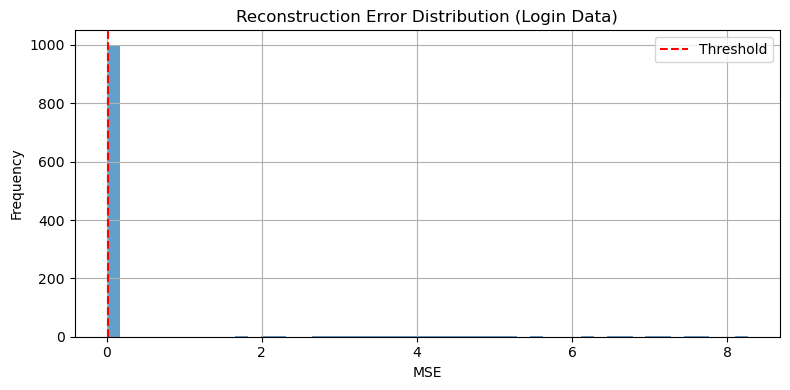

In [10]:
plt.figure(figsize=(8, 4))
plt.hist(df['reconstruction_error'], bins=50, alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution (Login Data)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧪 **7. Test a New Login Activity Sample**

In [11]:
# Simulate suspicious login attempt
new_sample = pd.DataFrame([{
    'login_hour': 1,
    'geo_distance_km': 2500,
    'failed_login_count': 6,
    'session_duration_sec': 45,
    'login_frequency_past_week': 25,
    'is_known_device': 0,
    'ip_reputation_score': 0.15,
    'weekday': 6  # Sunday
}])

# Scale and evaluate
new_scaled = scaler.transform(new_sample)
new_recon = autoencoder.predict(new_scaled)
new_error = np.mean(np.square(new_scaled - new_recon))

print(f"🔍 Reconstruction Error: {new_error:.4f}")
if new_error > threshold:
    print("🚨 The new login sample is an ANOMALY.")
else:
    print("✅ The new login sample is NORMAL.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
🔍 Reconstruction Error: 6.7459
🚨 The new login sample is an ANOMALY.


### 💾 **8. Export Detected Anomalies**

In [12]:
df[df['anomaly']].to_csv("login_anomalies_autoencoder.csv", index=False)
print("✅ Anomalies exported to 'login_anomalies_autoencoder.csv'")



✅ Anomalies exported to 'login_anomalies_autoencoder.csv'


### 🎯 Summary:
- Trained only on **normal login data**
- Detected outliers using **reconstruction error**
- You can now detect **compromised accounts, suspicious logins**, brute-force attempts, and more!